In [202]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from operator import itemgetter
from collections import OrderedDict

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

In [203]:
import torch
from torch import optim,nn
import torch.nn.functional as F
from torchvision import transforms as T,models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

plt.rcParams["backend"] = "module://matplotlib_inline.backend_inline"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [204]:
data = pd.read_csv('./data/nih/Data_Entry_2017.csv')
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


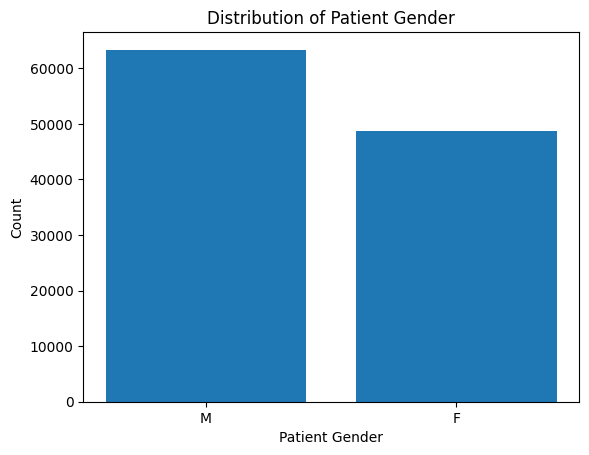

In [205]:
gender_counts = data['Patient Gender'].value_counts()

plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Patient Gender')
plt.ylabel('Count')
plt.title('Distribution of Patient Gender')
plt.show()

In [206]:
def convert_to_int(age_str):
    return int(age_str)

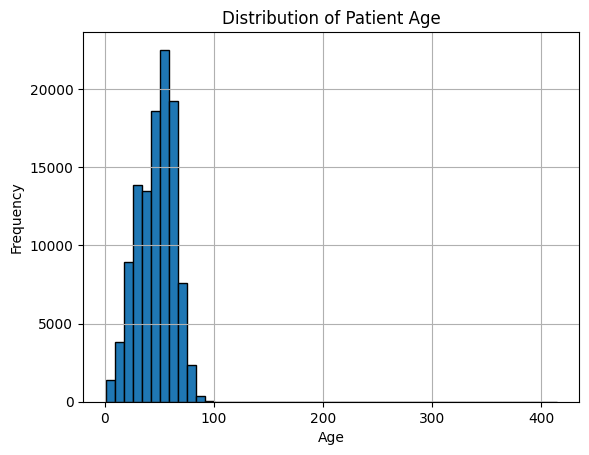

In [207]:
patient_age = data['Patient Age'].apply(convert_to_int)

plt.hist(patient_age, bins=50, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Patient Age')
plt.grid(True)  # Optionally, add grid lines
plt.show()

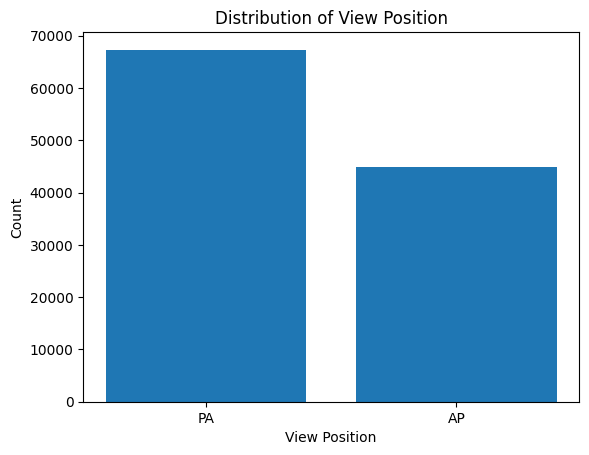

In [208]:
view_position_counts = data['View Position'].value_counts()

plt.bar(view_position_counts.index, view_position_counts.values)
plt.xlabel('View Position')
plt.ylabel('Count')
plt.title('Distribution of View Position')
plt.show()

In [209]:
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

for pathology in pathology_list :
    data[pathology] = data['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
    
data['No Findings'] = data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

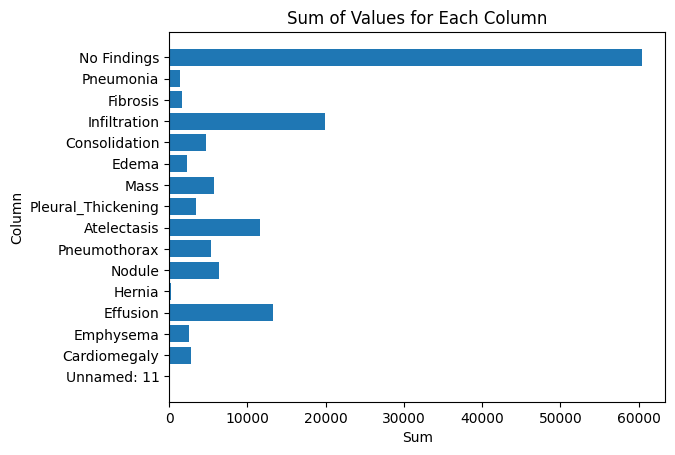

In [210]:
data = data.drop(data.columns[1:11], axis=1)

# Calculate the sum of each column excluding the first column
sum_per_column = data.iloc[:, 1:].sum()

# Plotting with Matplotlib
plt.barh(sum_per_column.index, sum_per_column.values)
plt.xlabel('Sum')
plt.ylabel('Column')
plt.title('Sum of Values for Each Column')
plt.show()


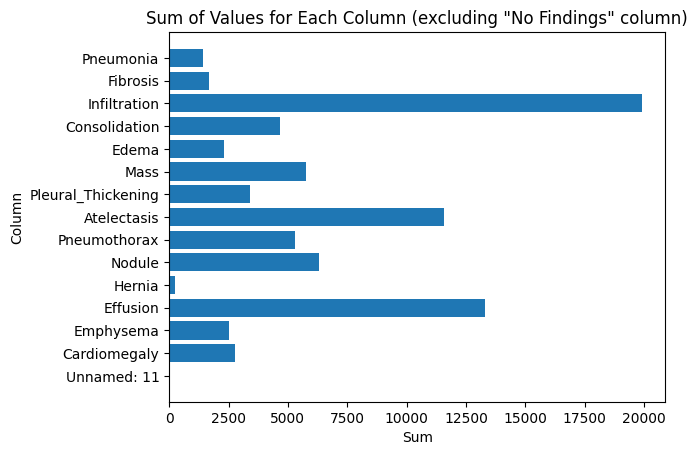

In [211]:
data = data.drop(['No Findings'], axis=1)

sum_per_column = data.iloc[:, 1:].sum()

plt.barh(sum_per_column.index, sum_per_column.values)
plt.xlabel('Sum')
plt.ylabel('Column')
plt.title('Sum of Values for Each Column (excluding "No Findings" column)')
plt.show()

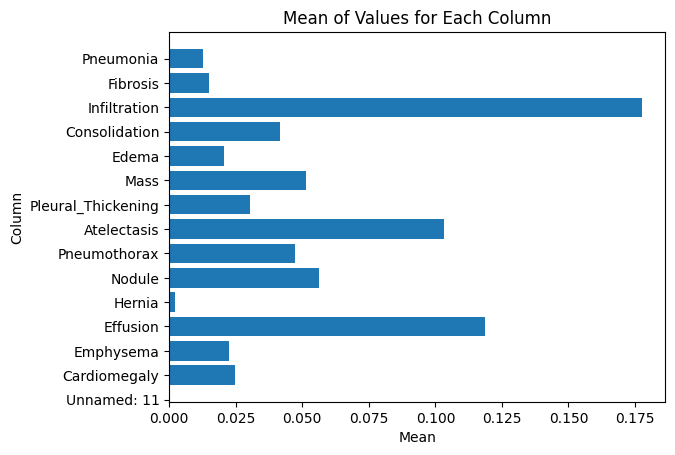

In [212]:
mean_per_column = data.iloc[:, 1:].mean()

plt.barh(mean_per_column.index, mean_per_column.values)
plt.xlabel('Mean')
plt.ylabel('Column')
plt.title('Mean of Values for Each Column')
plt.show()

In [213]:
def compute_class_freqs(labels):

    labels = np.array(labels)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies


In [214]:
freq_pos,freq_neg = compute_class_freqs(data.iloc[:,1:])

In [216]:
print(len(pathology_list))
print(len(freq_pos))
print(len(freq_neg))

14
15
15


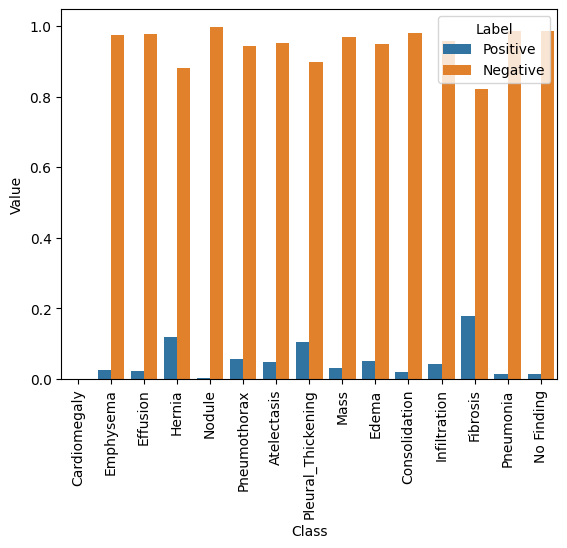

In [159]:
df_pos = pd.DataFrame({"Class": pathology_list, "Label": "Positive", "Value": freq_pos})
df_neg = pd.DataFrame([{"Class": pathology_list[l], "Label": "Negative", "Value": v} for l, v in enumerate(freq_neg)])

df = pd.concat([df_pos, df_neg], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=df)

In [217]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [218]:
df_pos = pd.DataFrame({"Class": pathology_list, "Label": "Positive", "Value": pos_contribution})
df_neg = pd.DataFrame([{"Class": pathology_list[l], "Label": "Negative", "Value": v} 
                       for l, v in enumerate(neg_contribution)])

df = pd.concat([df_pos, df_neg], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label", data=df)

ValueError: All arrays must be of the same length

In [219]:
def weighted_loss(pos_weights, neg_weights, y_pred, y_true, epsilon=1e-7):

    loss = 0.0
    for i in range(len(pos_weights)):
        loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))
        loss_neg = -1 * torch.mean(neg_weights[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))
        loss += loss_pos + loss_neg
    return loss

In [220]:
class NIH_Dataset(Dataset):

    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir 
        self.transform = transform 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_file = self.img_dir + self.data.iloc[:,0][idx]
        img = Image.open(img_file).convert('RGB')
        label = np.array(self.data.iloc[:,1:].iloc[idx])

        if self.transform:
            img = self.transform(img)

        return img,label

In [221]:
data_transform = T.Compose([
    T.RandomRotation((-20,+20)),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [222]:
trainds = NIH_Dataset(data,
                      img_dir = './data/nih/images_001/images/',
                      transform = data_transform)

In [223]:
def deprocess(img):
    img = img.permute(1,2,0)
    img = img * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    return img

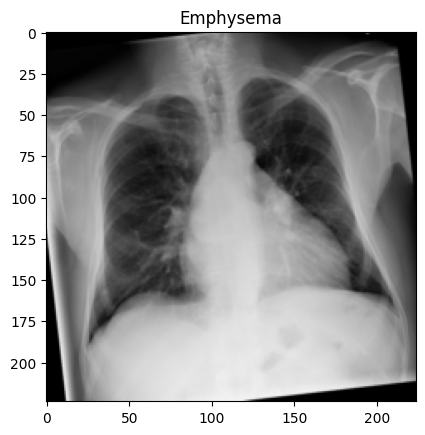

In [224]:
image, label = trainds[0]
class_labels = list(np.where(label==1)[0])
plt.imshow(deprocess(image))
plt.title(itemgetter(*class_labels)(pathology_list));

In [225]:
trainset, validset, testset = random_split(trainds, [89696,11212,11212])

print("Length of trainset : {}".format(len(trainset)))
print("Length of testset : {}".format(len(testset)))
print("Length of validset : {}".format(len(validset)))

Length of trainset : 89696
Length of testset : 11212
Length of validset : 11212


In [226]:
trainloader = DataLoader(trainset,
                         batch_size = 32,
                         shuffle = True)

validloader = DataLoader(validset,
                         batch_size = 32,
                         shuffle = False)

testloader = DataLoader(testset,
                        batch_size = 32,
                        shuffle = True)

In [227]:
model = models.resnet18()
model.load_state_dict(torch.load('./input/pretrained-model-weights-pytorch/resnet18-5c106cde.pth'))

<All keys matched successfully>

In [228]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(512, 14),
    nn.Sigmoid()
)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [229]:
optimizer = optim.Adam(model.parameters(),
                       lr = 0.0001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 factor = 0.1,
                                                 patience = 4)
epochs = 15
valid_loss_min = np.Inf

In [230]:
for i in range(epochs):

    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 

    model.train()
    for images,labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        ps = model(images)
        print(ps.shape)
        print(labels.shape)
        loss = weighted_loss(pos_weights,neg_weights,ps,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    avg_train_loss = train_loss / len(trainloader)

    model.eval()
    with torch.no_grad():
        for images,labels in tqdm(validloader):
            images = images.to(device)
            labels = labels.to(device)

            ps = model(images)
            loss = weighted_loss(pos_weights,neg_weights,ps,labels)
            valid_loss += loss.item()
        avg_valid_loss = valid_loss / len(validloader)

    schedular.step(avg_valid_loss)

    if avg_valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
        torch.save({
            'epoch' : i,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'valid_loss_min' : avg_valid_loss
        },'Pneumonia_model.pt')

        valid_loss_min = avg_valid_loss

    print("Epoch : {} Train Loss : {:.6f} ".format(i+1,avg_train_loss))
    print("Epoch : {} Valid Loss : {:.6f} ".format(i+1,avg_valid_loss))

  0%|                                                  | 0/2803 [00:00<?, ?it/s]

torch.Size([32, 14])
torch.Size([32, 15])


IndexError: index 14 is out of bounds for dimension 1 with size 14